In [24]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 운영 체제 정보를 확인하고, matplotlib을 사용하여 그래프 그릴 준비하기
import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Sorry')

plt.rcParams['axes.unicode_minus'] = False

In [25]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

# images 텐서 크기 확인
images.shape

TensorShape([2, 70, 120, 3])

In [26]:
tf.random.set_seed(42)  # 재현성 보장
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

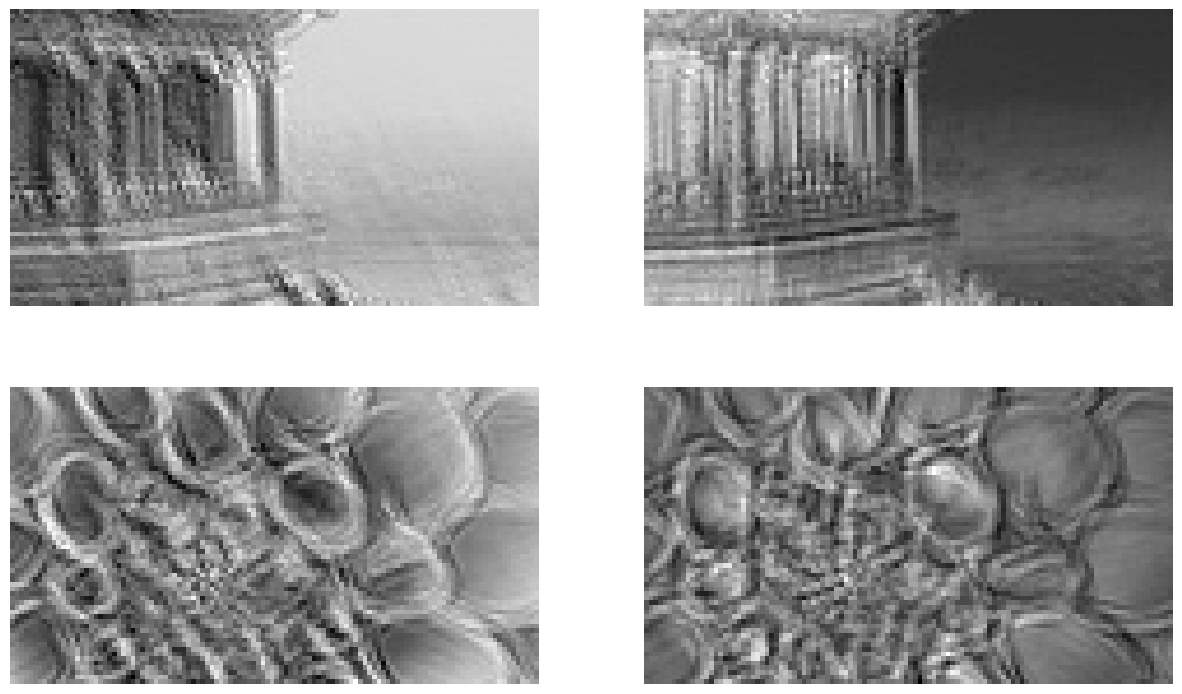

In [27]:
# 각 이미지에 대해 두 개의 출력 특성 맵을 표시.

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [28]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

# 출력의 크기 확인
fmaps.shape

TensorShape([2, 64, 114, 32])

In [29]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same')
fmaps = conv_layer(images)

# 출력의 크기 확인
fmaps.shape

TensorShape([2, 70, 120, 32])

In [30]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same',
                                   strides=2)
fmaps = conv_layer(images)

# 출력의 크기 확인
fmaps.shape

TensorShape([2, 35, 60, 32])

In [31]:
kernels, biases = conv_layer.get_weights()

print(kernels.shape)
print(biases.shape)

(7, 7, 3, 32)
(32,)


In [32]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [33]:
output = max_pool(images)

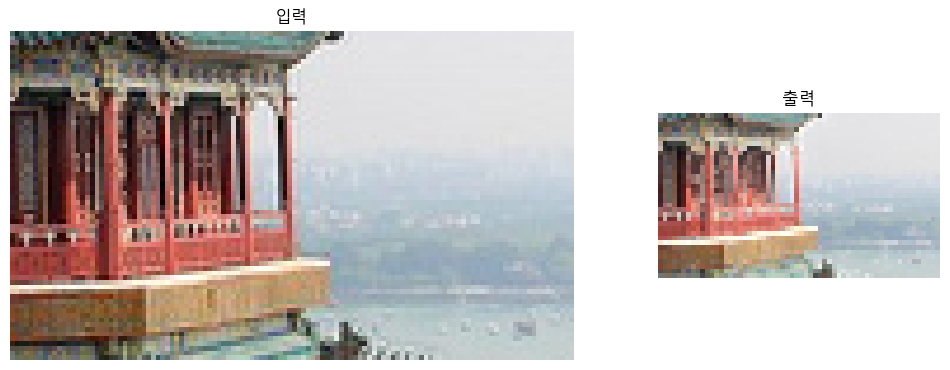

In [34]:
#  stride = 2인 최대 풀링이 어떻게 보이는지 보여주는 코드.

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("입력")
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("출력")
ax2.imshow(output[0])  # 첫 번째 이미지의 출력 그리기.
ax2.axis("off")
plt.show()

In [35]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1]는 채널 개수.
        groups = shape[-1] // self.pool_size  # 채널 그룹 수
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [36]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [37]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [38]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [39]:
# mnist 데이터 세트를 로드하고 입력에 채널 축을 추가
# 값을 0-1 범위로 스케일링하고 데이터셋을 분할.
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [40]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
]) 

In [ ]:
# 아래 셀 수행 오래 걸리는 편

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # 새 이미지가 있다고 가정합니다.
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 65ms/step - accuracy: 0.5939 - loss: 1.1276 - val_accuracy: 0.8716 - val_loss: 0.3670
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 123s 71ms/step - accuracy: 0.8432 - loss: 0.4628 - val_accuracy: 0.8730 - val_loss: 0.3453
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 119s 69ms/step - accuracy: 0.8747 - loss: 0.3796 - val_accuracy: 0.8900 - val_loss: 0.3069
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - accuracy: 0.8894 - loss: 0.3340 - val_accuracy: 0.9004 - val_loss: 0.2856
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 113s 65ms/step - accuracy: 0.8983 - loss: 0.2980 - val_accuracy: 0.9032 - val_loss: 0.2717
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 117s 68ms/step - accuracy: 0.9046 - loss: 0.2793 - val_accuracy: 0.9068 - val_loss: 0.2664
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 112s 65ms/step - accuracy: 0.9132 - loss: 0.2617 - val_accuracy: 0.8960 - val_loss: 0.2965
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 113s 66ms/step - accuracy: 

In [41]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [42]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [43]:
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')

In [46]:
# 샘플 이미지 로드
images = load_sample_images()['images']

# 이미지를 텐서로 변환
images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

# Resizing 레이어 적용
images_resized = tf.keras.layers.Resizing(
    height=224, width=224, crop_to_aspect_ratio=True
)(images_tensor)

print(images_resized.shape)  # 출력 결과 확인

(2, 224, 224, 3)


In [48]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

# 사전 훈련된 모델 사용해 예측 수행
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(2, 1000)

In [50]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_K[image_index]:
        print(f' {class_id} - {name:12s} {y_proba:.2%}')

Image #0
 n03877845 - palace       54.69%
 n03781244 - monastery    24.72%
 n02825657 - bell_cote    18.55%
Image #1
 n04522168 - vase         32.66%
 n11939491 - daisy        17.81%
 n03530642 - honeycomb    12.06%


In [52]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

print(dataset_size)
print(class_names)
print(n_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


In [58]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)           

In [59]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

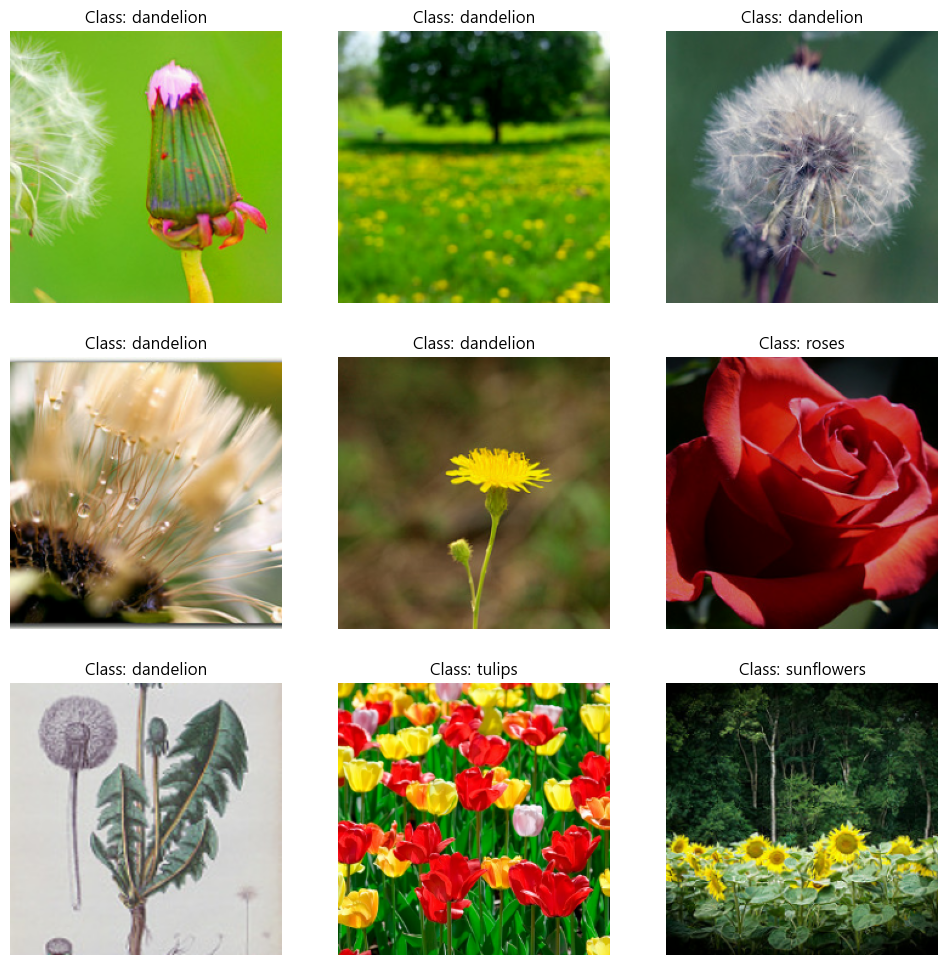

In [60]:
# valid_set의 첫 번째 배치에 처음 9개의 이미지 표시.

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # imshow()를 위해 0-1로 조정.
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [62]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

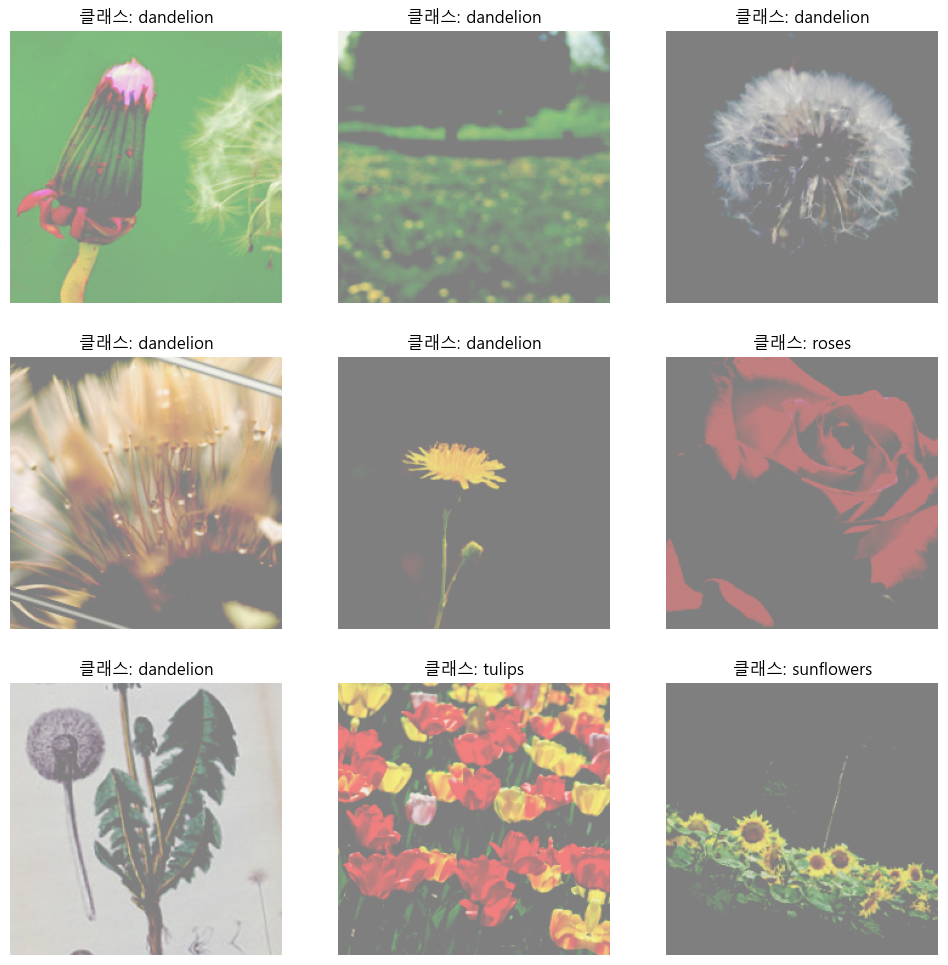

In [63]:
# 증식 후 처음 9개의 이미지 동일하게 표시.

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # imshow()를 위해 이미지 크기를 0-1 범위로 조정.
        # 데이터 증식으로 인해 일부 값이 범위를 벗어날 수 있으므로
        # (예: 이 경우 RandomContrast) 결과를 해당 범위로 클리핑.
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"클래스: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [64]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAvgPool2D()(base_model.output) # 또는 GlobalAveragePooling2D
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [65]:
for layer in base_model.layers:
    layer.trainable = False

In [66]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.7198 - loss: 0.8869 - val_accuracy: 0.8621 - val_loss: 0.5561
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9016 - loss: 0.3591 - val_accuracy: 0.8403 - val_loss: 0.6776
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9437 - loss: 0.1791 - val_accuracy: 0.8385 - val_loss: 0.6046


In [67]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_6          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_38 67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [68]:
# 잔차 유닛 중 7번째 유닛의 시작 부분 동결 해제
for layer in base_model.layers[56:]:
    layer.trainable = True

# 층 동결이나 해제 시에는 모델 다시 컴파일 필요
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 397s 5s/step - accuracy: 0.8772 - loss: 0.3813 - val_accuracy: 0.8621 - val_loss: 0.5758
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.9790 - loss: 0.0574 - val_accuracy: 0.9056 - val_loss: 0.3700
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 0.8984 - val_loss: 0.3421
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 396s 5s/step - accuracy: 0.9937 - loss: 0.0160 - val_accuracy: 0.9111 - val_loss: 0.3615
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.9093 - val_loss: 0.3474
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.9987 - loss: 0.0083 - val_accuracy: 0.9129 - val_loss: 0.3769
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 0.9074 - val_loss: 0.3975
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 397s 5s/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9111 - v

In [70]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAvgPool2D()(base_model.output) # 또는 GlobalAveragePooling2D
class_output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=['accuracy'])

In [71]:
# 임의의 타깃 바운딩 박스를 사용하여 모델 훈련
# (실제에서는 대신 적절한 타깃을 생성해야 함).

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 3, 32), dtype=float32, path=block1_conv1/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.